In [1]:
import torch
import pickle
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
from einops import rearrange, repeat
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_config import line_colors, lr_line_style, zs_line_style,ccs_line_style, num_hidden_layers,layers_arr

/mnt/ssd-2/spar/waree/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def load_and_stack_layers(num_layers: int, reporter_type: 'str', prefix_path: str) -> torch.Tensor:
    layers = []
    if reporter_type == 'lr' or reporter_type == 'lr2':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = pickle.load(open(layer_path, "rb"))
            layers.append(layer.linear.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'vinc':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'ccs':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.probe[0].weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked

def get_norm_weights(data: dict, dataset: str, ccs_path: str, vinc_path: str, lr_path: str):
    
    for reporter,path in zip(['ccs','vinc','lr'], [ccs_path,vinc_path,lr_path]):
        weights = load_and_stack_layers(num_hidden_layers, reporter, path)
        magnitude = torch.norm(weights, dim=-1, keepdim=True)
        data[(dataset, reporter)] = weights/magnitude
    

def similarity(rep1_normalized, rep2_normalized):
    cosine_sim = torch.einsum("ij,ij->i", rep1_normalized, rep2_normalized)
    return cosine_sim


def similarity_single_layer(rep1_normalized, rep1_layer: int, rep2_normalized):
    cosine_sim = torch.einsum("j,ij->i", rep1_normalized[rep1_layer], rep2_normalized)
    return cosine_sim

In [6]:
data = {}

d_array = [1,5,10,50,100,250,500,750,1000]

for d in d_array:

    dataset = f"arith{d}"

    ccs_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/arithmetic_2as_1to{d}/ccs/reporters'
    lr_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/arithmetic_2as_1to{d}/vinc/lr_models'
    vinc_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/arithmetic_2as_1to{d}/vinc/reporters'

    get_norm_weights(data, dataset, ccs_path, vinc_path, lr_path)

In [36]:
for d in [0,10,30,50]:

    dataset = f"imdb_misspelled_{d}"

    lr_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/ccs/lr_models'
    ccs_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/ccs/reporters'
    vinc_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/vinc/reporters'

    get_norm_weights(data, dataset, ccs_path, vinc_path, lr_path)

In [23]:
sim = {}

for d in d_array:

    dataset = f"arith{d}"
    sim[(dataset, 'ccs-vinc')] = similarity(data[(dataset,'ccs')], data[(dataset,'vinc')])
    sim[(dataset, 'lr-vinc')] = similarity(data[(dataset,'lr')], data[(dataset,'vinc')])
    sim[(dataset, 'lr-ccs')] = similarity(data[(dataset,'lr')], data[(dataset,'ccs')])
    sim[(dataset, f'ccs-1-{d}')] = similarity(data[('arith1000','ccs')], data[(dataset,'ccs')])
    sim[(dataset, f'vinc-1-{d}')] = similarity(data[('arith1000','vinc')], data[(dataset,'vinc')])
    sim[(dataset, f'vinc-{d}-layer20')] = similarity_single_layer(data[(dataset,'vinc')],20,data[(dataset,'vinc')])
    sim[(dataset, f'lr-1-{d}')] = similarity(data[('arith1000','lr')], data[(dataset,'lr')])
    sim[(dataset, f'lr-{d}-layer20')] = similarity_single_layer(data[(dataset,'lr')],20,data[(dataset,'lr')])
    sim[(dataset, f'ccs-{d}-layer20')] = similarity_single_layer(data[(dataset,'ccs')],20,data[(dataset,'ccs')])

In [37]:
for d in [0,10,30,50]:

    dataset = f"imdb_misspelled_{d}"
    sim[(dataset, 'lr-vinc')] = similarity(data[(dataset,'lr')], data[(dataset,'vinc')])
    sim[(dataset, 'lr-ccs')] = similarity(data[(dataset,'lr')], data[(dataset,'ccs')])
    sim[(dataset, 'ccs-vinc')] = similarity(data[(dataset,'ccs')], data[(dataset,'vinc')])
    sim[(dataset, f'lr-0-{d}')] = similarity(data[("imdb_misspelled_0",'lr')], data[(dataset,'lr')])
    sim[(dataset, f'ccs-0-{d}')] = similarity(data[('imdb_misspelled_0','ccs')], data[(dataset,'ccs')])
    sim[(dataset, f'vinc-0-{d}')] = similarity(data[('imdb_misspelled_0','vinc')], data[(dataset,'vinc')])
    sim[(dataset, f'vinc-{d}-layer20')] = similarity_single_layer(data[(dataset,'vinc')],20,data[(dataset,'vinc')])
    sim[(dataset, f'ccs-{d}-layer20')] = similarity_single_layer(data[(dataset,'ccs')],20,data[(dataset,'ccs')])
    sim[(dataset, f'lr-{d}-layer20')] = similarity_single_layer(data[(dataset,'lr')],20,data[(dataset,'lr')])

In [38]:
sim[('between','vinc-ccs')] = similarity(data[('arith1000','vinc')], data[('imdb_misspelled_0','ccs')])
sim[('between','vinc-vinc')] = similarity(data[('arith1000','vinc')], data[('imdb_misspelled_0','vinc')])
sim[('between','lr-lr')] = similarity(data[('arith1000','lr')], data[('imdb_misspelled_0','lr')])

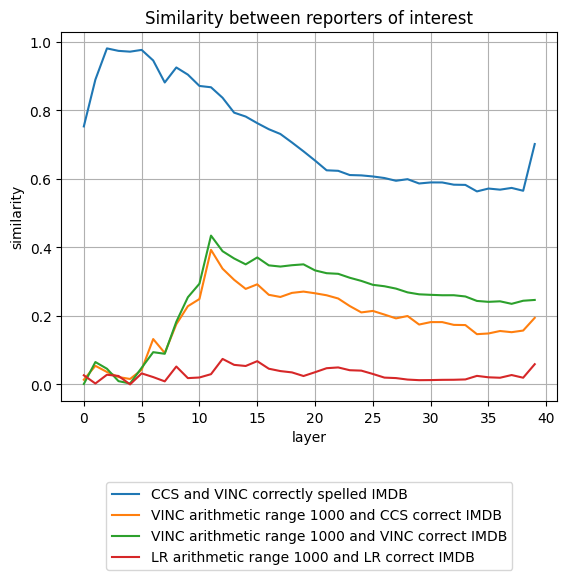

In [45]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between reporters of interest")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

ax.plot(layers_arr, np.absolute(sim[('imdb_misspelled_0', 'ccs-vinc')]), label="CCS and VINC correctly spelled IMDB")
ax.plot(layers_arr, np.absolute(sim[('between','vinc-ccs')]), label="VINC arithmetic range 1000 and CCS correct IMDB")
ax.plot(layers_arr, np.absolute(sim[('between','vinc-vinc')]), label="VINC arithmetic range 1000 and VINC correct IMDB")
ax.plot(layers_arr, np.absolute(sim[('between','lr-lr')]), label="LR arithmetic range 1000 and LR correct IMDB")

ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')
plt.show()

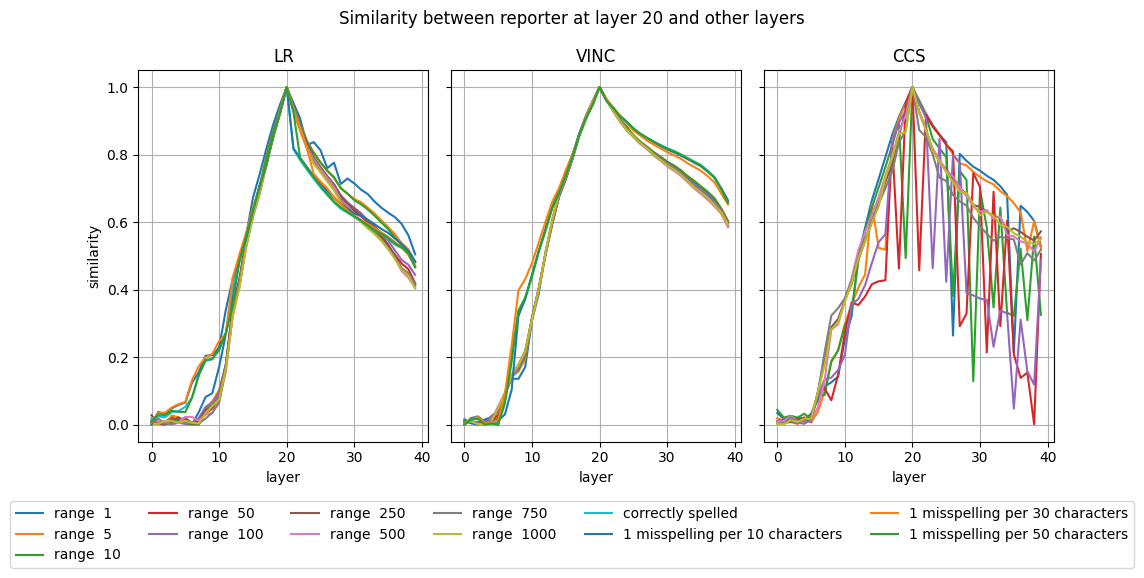

In [46]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5), sharey = True)

# Set big title for the whole figure
fig.suptitle("Similarity between reporter at layer 20 and other layers")

ax = axs[0]
ax.set_title(fr"LR")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:
    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-{d}-layer20')]), label=f"range  {d}")

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-{d}-layer20')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-{d}-layer20')]), label = f"1 misspelling per {d} characters")


handles, labels = axs[0].get_legend_handles_labels()  # Assuming all subplots have the same legend
fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.15), loc='lower center', ncol=len(labels)/2)

# Adjust the layout to make room for the legend
fig.subplots_adjust(bottom = 0.2)

fig.tight_layout(pad=2) 

ax = axs[1]
ax.set_title(fr"VINC")
ax.set_xlabel("layer")
ax.grid(True)

for d in d_array:
    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-{d}-layer20')]), label=f"range  {d}")

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-{d}-layer20')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-{d}-layer20')]), label = f"1 misspelling per {d} characters")

ax = axs[2]
ax.set_title(fr"CCS")
ax.set_xlabel("layer")
ax.grid(True)

for d in [1,10,100,500,1000]:
    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-{d}-layer20')]), label=f"range {d}")

for d in [0,10,30,50]:

    dataset = f'imdb_misspelled_{d}'
    if d == 0:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-{d}-layer20')]), label = "correctly spelled")

    else:
        ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-{d}-layer20')]), label = f"1 misspelling per {d} characters")

plt.tight_layout()
plt.show()

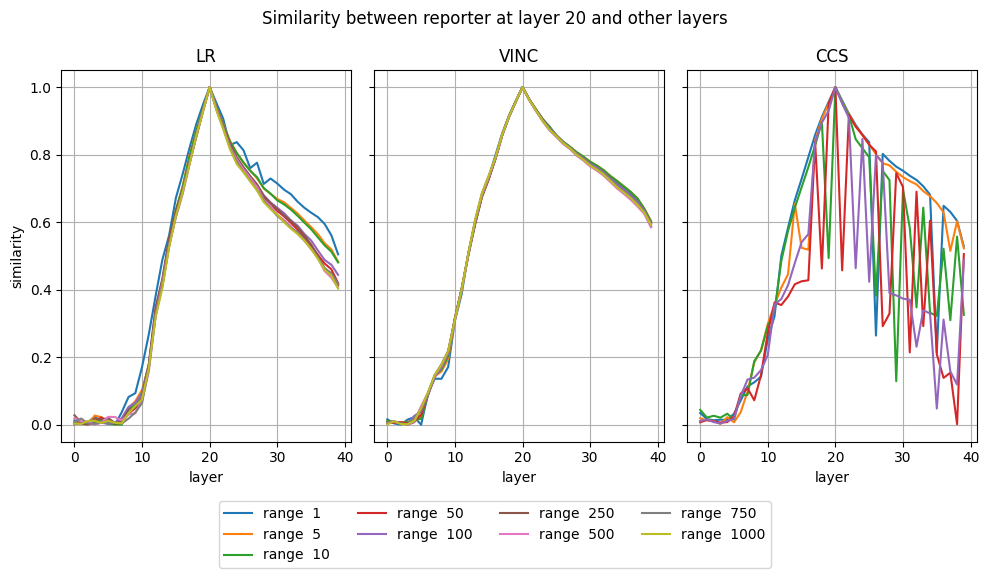

In [24]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5), sharey = True)

# Set big title for the whole figure
fig.suptitle("Similarity between reporter at layer 20 and other layers")

ax = axs[0]
ax.set_title(fr"LR")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:
    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-{d}-layer20')]), label=f"range  {d}")

handles, labels = axs[0].get_legend_handles_labels()  # Assuming all subplots have the same legend
fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.15), loc='lower center', ncol=len(labels)/2)

# Adjust the layout to make room for the legend
fig.subplots_adjust(bottom = 0.2)

fig.tight_layout(pad=2) 

ax = axs[1]
ax.set_title(fr"VINC")
ax.set_xlabel("layer")
ax.grid(True)

for d in d_array:
    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-{d}-layer20')]), label=f"range  {d}")

ax = axs[2]
ax.set_title(fr"CCS")
ax.set_xlabel("layer")
ax.grid(True)

for d in [1,10,100,500,1000]:
    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-{d}-layer20')]), label=f"range   {d}")

plt.tight_layout()
plt.show()


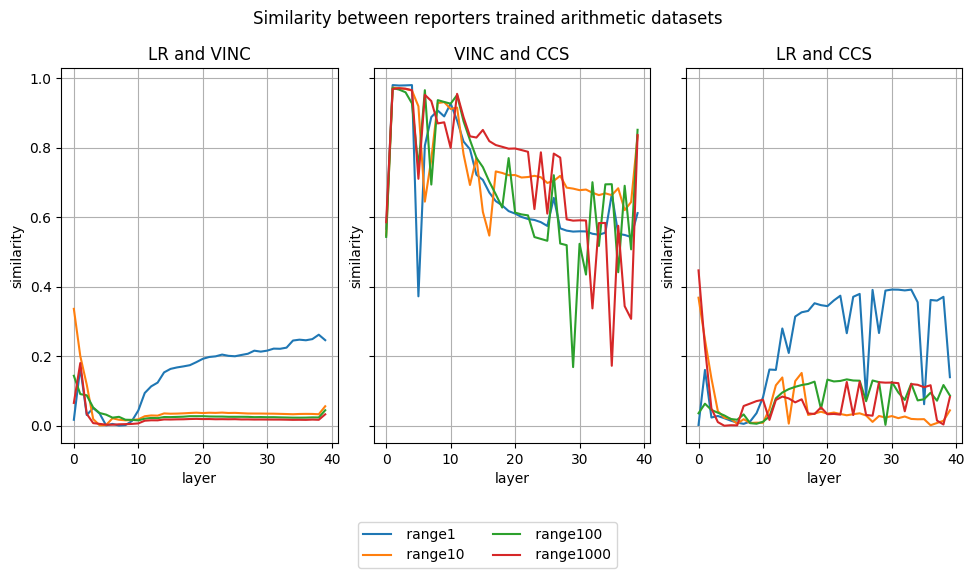

In [27]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5), sharey = True)

# Set big title for the whole figure
fig.suptitle("Similarity between reporters trained arithmetic datasets")

ax = axs[0]
ax.set_title(fr"LR and VINC")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,10,100,1000]:

    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, 'lr-vinc')]), label = f" range{d}")

                
handles, labels = axs[0].get_legend_handles_labels()  # Assuming all subplots have the same legend
fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.15), loc='lower center', ncol=len(labels)/2)

# Adjust the layout to make room for the legend
fig.subplots_adjust(bottom = 0.2)

fig.tight_layout(pad=1) 

ax = axs[1]
ax.set_title(fr"VINC and CCS")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,10,100,1000]:

    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, 'ccs-vinc')]), label = f" range{d}")

ax = axs[2]
ax.set_title(fr"LR and CCS")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,10,100,1000]:

    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, 'lr-ccs')]), label = f" range{d}")



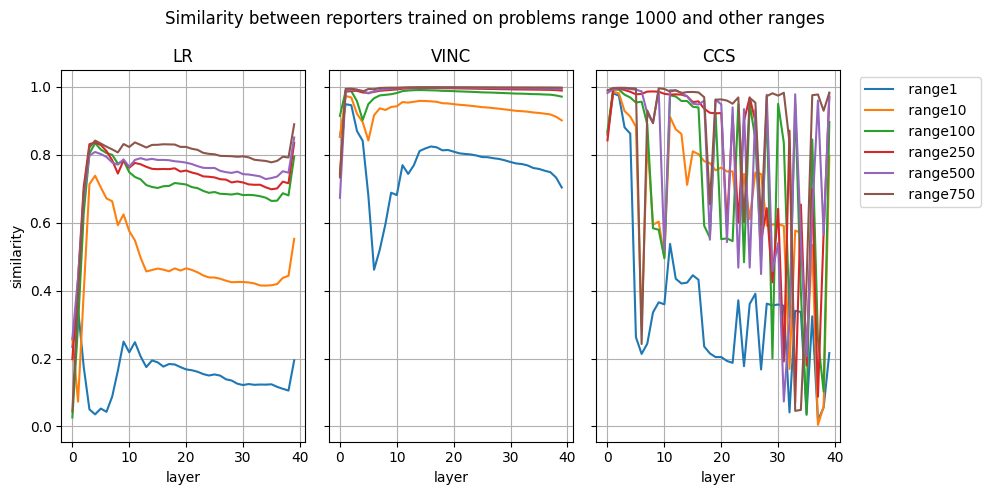

In [34]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5), sharey = True)

# Set big title for the whole figure
fig.suptitle("Similarity between reporters trained on problems range 1000 and other ranges")

ax = axs[0]
ax.set_title(fr"LR")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,10,100,250,500,750]:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-1-{d}')]), label = f" range{d}")

#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axs[1]
ax.set_title(fr"VINC")
ax.set_xlabel("layer")
ax.grid(True)

for d in [1,10,100,250,500,750]:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-1-{d}')]), label = f" range{d}")

#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axs[2]
ax.set_title(fr"CCS")
ax.set_xlabel("layer")
ax.grid(True)

for d in [1,10,100,250,500,750]:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-1-{d}')]), label = f" range{d}")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

KeyError: ('arith1', 'arith1', 'vinc')

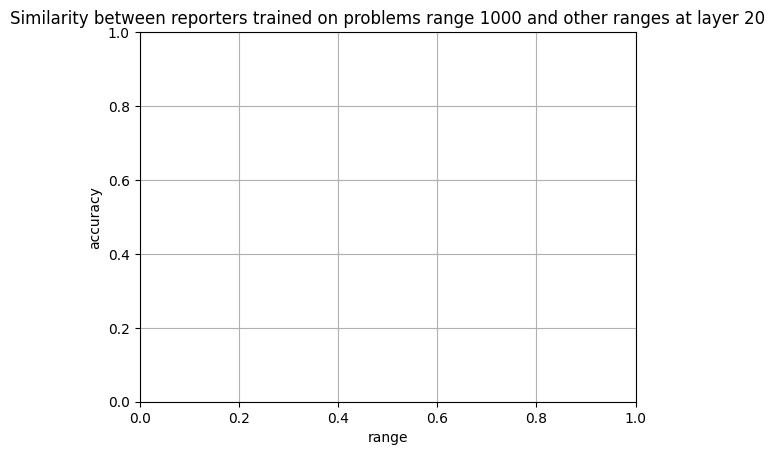

In [35]:
# transfer at layer 20

fig, ax = plt.subplots()
ax.set_title(fr"Similarity between reporters trained on problems range 1000 and other ranges at layer 20")
ax.set_xlabel("range")
ax.set_ylabel("accuracy")
ax.grid(True)

layer = 20
lr = []
vinc = []

d_arr = [1,5,10,50,100,250,500,750,1000]

for d in d_arr:

    dataset = f"arith{d}"

    #origin
    experiment = data[(dataset, dataset, 'vinc')]
    acc_vinc.append(experiment.loc[layer, 'acc'])
    acc_lr.append(experiment.loc[layer, 'lr_acc'])

    #transfer_arith
    experiment = data[(origin_dataset_arith, dataset, 'vinc')]
    acc_vinc_transfer.append(experiment.loc[layer, 'acc'])
    acc_lr_transfer.append(experiment.loc[layer, 'lr_acc'])

    #transfer_imdb
    experiment = data[(origin_dataset_imdb, dataset, 'vinc')]
    acc_vinc_imdb.append(experiment.loc[layer, 'acc'])
    acc_lr_imdb.append(experiment.loc[layer, 'lr_acc'])
    experiment = data[(origin_dataset_imdb, dataset, 'ccs')]
    acc_ccs_imdb.append(experiment.loc[layer, 'acc'])


ax.plot(d_arr, acc_vinc, label=f'VINC trained on each range', color = 'k')
ax.scatter(d_arr, acc_vinc, color = 'k')
ax.plot(d_arr, acc_lr, label=f'LR', color = 'k', linestyle=lr_line_style)
ax.scatter(d_arr, acc_lr, color = 'k')

ax.plot(d_arr, acc_vinc_transfer, label=f'VINC trained on range 1000', color = 'b')
ax.scatter(d_arr, acc_vinc_transfer, color = 'b')
ax.plot(d_arr, acc_lr_transfer, label=f'LR', color = 'b', linestyle=lr_line_style)
ax.scatter(d_arr, acc_lr_transfer, color = 'b')

ax.plot(d_arr, acc_vinc_imdb, label=f'VINC trained on correctly spelled IMDB', color = 'r')
ax.scatter(d_arr, acc_vinc_imdb, color = 'r')
ax.plot(d_arr, acc_ccs_imdb, label=f'CCS trained on correctly spelled IMDB', color = 'r', linestyle=ccs_line_style)
ax.scatter(d_arr, acc_ccs_imdb, color = 'r')
ax.plot(d_arr, acc_lr_imdb, label=f'LR', color = 'r', linestyle=lr_line_style)
ax.scatter(d_arr, acc_lr_imdb, color = 'r')
            
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Ungrouped

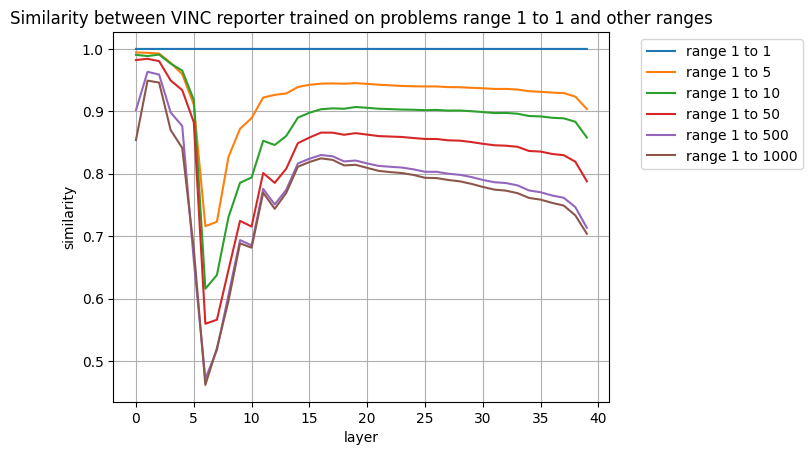

In [23]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between VINC reporter trained on problems range 1000 and other ranges")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-1-{d}')]), label = f" range{d}")
                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

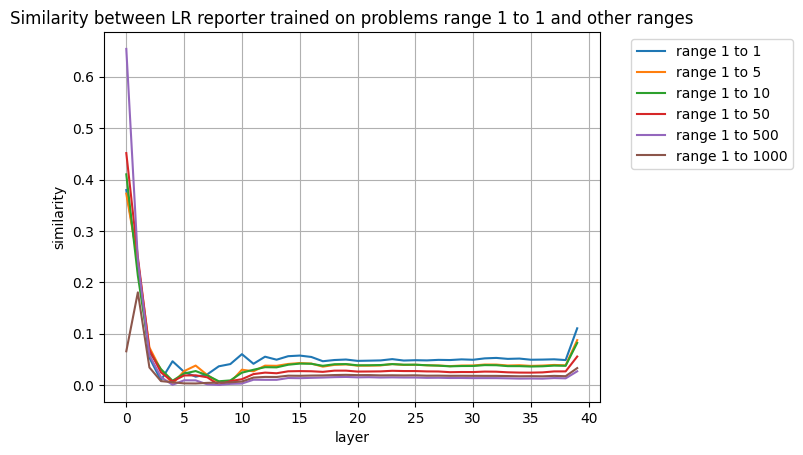

In [24]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between LR reporter trained on problems range 1000 and other ranges")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-1-{d}')]), label = f" range{d}")
                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

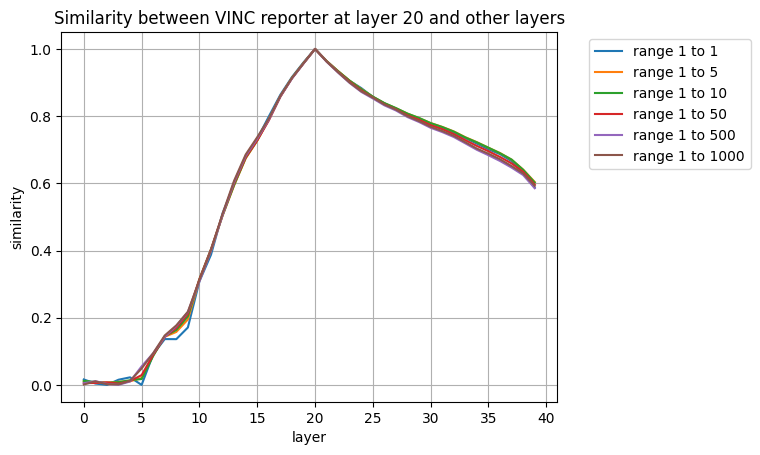

In [21]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between VINC reporter at layer 20 and other layers")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:

    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-{d}-layer20')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

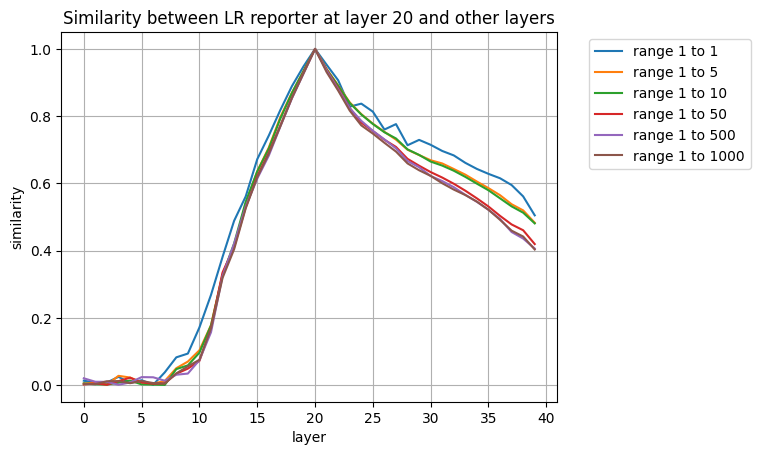

In [25]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between LR reporter at layer 20 and other layers")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:

    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-{d}-layer20')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

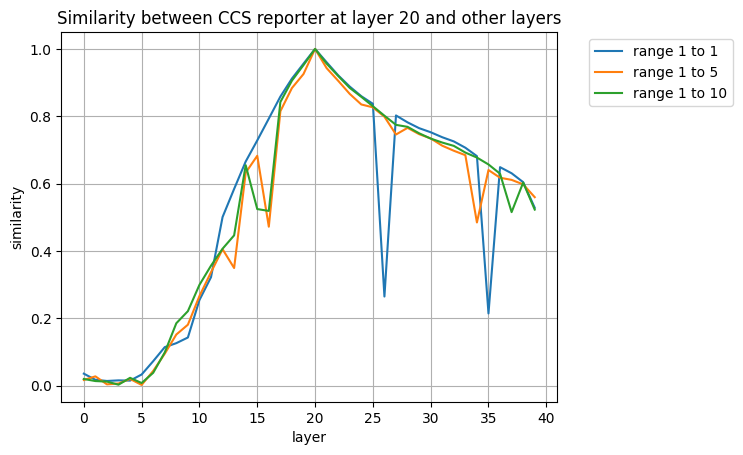

In [35]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between CCS reporter at layer 20 and other layers")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,5,10]:

    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-{d}-layer20')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

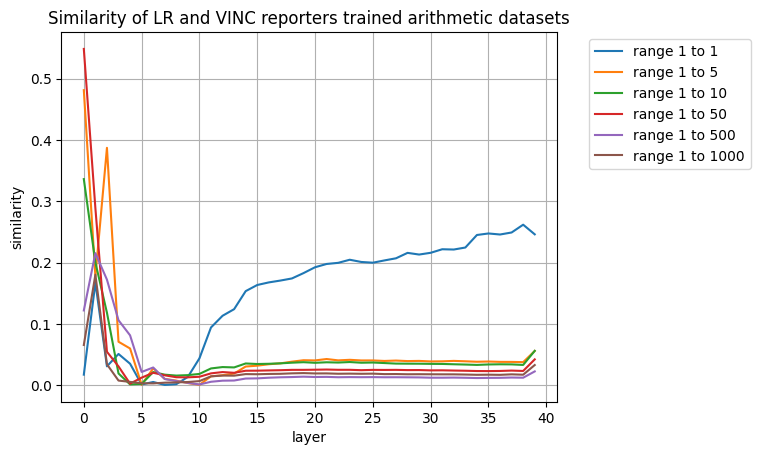

In [26]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity of LR and VINC reporters trained arithmetic datasets")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:

    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, 'lr-vinc')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

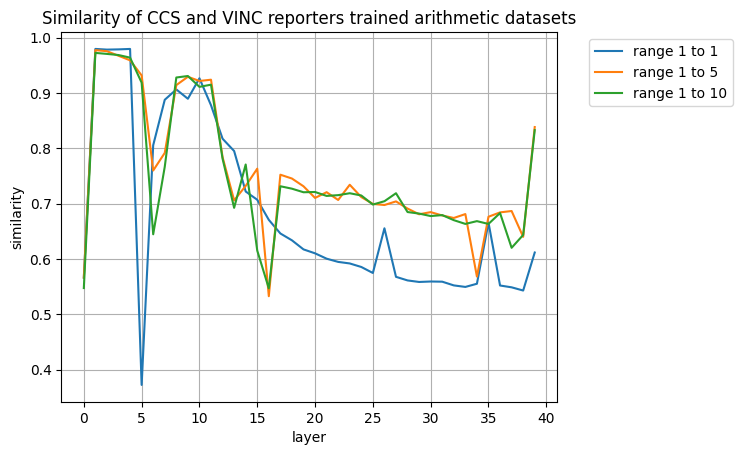

In [21]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity of CCS and VINC reporters trained arithmetic datasets")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,5,10]:

    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, 'ccs-vinc')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

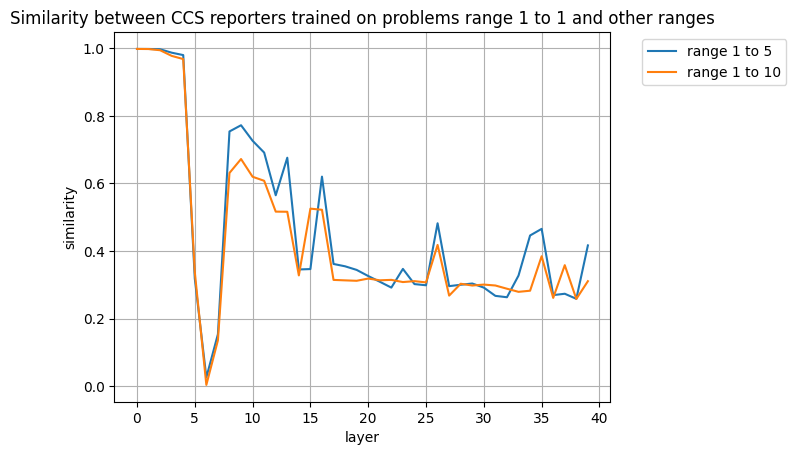

In [36]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between CCS reporters trained on problems range 1 and other ranges")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [5,10]:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-1-{d}')]), label = f" range{d}")
                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()